## Convert imaging data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from showit import image

In [3]:
from skimage.io import imsave

In [4]:
from os.path import exists
from os import mkdir
from json import dump

###Set directory and session information

In [5]:
directory = '/tier2/freeman/Nick/sessions'

## Load data

In [7]:
key = '000222'
path = directory + '/' + key
print path
print exists(path)

/tier2/freeman/Nick/sessions/000222
True


In [8]:
import mesoscope as ms

In [9]:
import thunder as td

In [10]:
rawData = td.images.fromtif(path + '/images-raw/', nplanes=1, engine = sc)

In [81]:
foo = rawData.values.reshape((8753,8,300,300), 'C')

In [42]:
bar = td.images.Images(foo)

In [44]:
bar.count()

70024

In [28]:
rawDataSm = rawData[15:183]

In [33]:
data = rawDataSm

In [30]:
t, z = rawDataSm.shape[0]/8, 8
x, y = rawData.shape[1:]
#swapped = rawData.values.reshape(z, t, x, y).transpose(1, 0, 2, 3).swap((1), ())
swapped = rawDataSm.values.reshape(t, z, x, y).swap((1), ())
reshaped = td.images.Images(swapped)

In [31]:
img = reshaped.mean().toarray()

In [11]:
rawData, rawMetadata = ms.load(path + '/images-raw/', engine = sc)
data, meta = ms.convert(rawData, rawMetadata)

In [13]:
print data
print '\n', meta

Images
mode: spark
dtype: int16
shape: (202, 2100, 2100)

{'nrois': 1, 'power': 100, 'nchannels': 1, 'nplanes': 1, 'averaging': 1000, 'depths': 200, 'rois': [{'depths': 0.0, 'npixels': [2100.0, 2100.0], 'center': [-3.1720657846433042e-17, 0.0], 'size': [4.2000000005249998, 4.2000000005250007]}], 'shape': (202, 2100, 2100), 'volumeRate': 1.59768655}


## Inspect data

In [90]:
#img = data.mean().toarray()
#img = data[0].toarray()

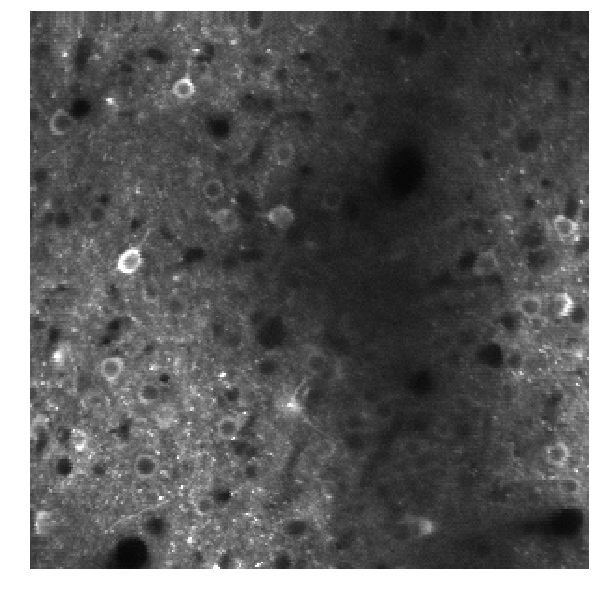

In [26]:
image(img[2], clim=(0, 3.5*img.mean()), size = 10);

##Save binary images

In [34]:
if not exists(path + '/images'):
    mkdir(path + '/images')
data.tobinary(path + '/images', overwrite=True)

##Save summary data

###Meta data

In [31]:
if not exists(path + '/summary'):
    mkdir(path + '/summary')
with open(path + '/summary/meta.json', 'w') as fid:
    dump(meta, fid, indent=2)

OSError: [Errno 17] File exists: '/tier2/freeman/Nick/sessions/000207/summary'

###Raw tiffs

In [32]:
imsave(path + '/summary/rawVol.tif', (img.clip(0,2**13-1)/32).astype('uint8'), plugin='tifffile', photometric='minisblack')

###Normalized tiffs

In [18]:
from numpy import array
def normalize(oim):
    """
    Normalize a three dimensional volume.
    """
    if not oim.ndim == 3:
        raise Exception('image must be three dimensional')
    means = oim.mean(axis=(1, 2), dtype='float32')
    maximum = means.max()
    return array([oim[i]*maximum/means[i] for i in range(oim.shape[0])])

In [19]:
norm = normalize(img).astype('float32')
#norm = data.map(normalize)

In [21]:
imsave(path + '/summary/raw-norm.tif', (norm.clip(0,2**13-1)/32).astype('uint8'), plugin='tifffile', photometric='minisblack')